In [126]:
example_name = "Binary_Test_New"
test_dir = f"test_dirs/{example_name}"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $test_dir
    os.chdir(test_dir)
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
print(f"Current working directory: {os.getcwd()}")
print(f"Repository root directory: {repo_root}")

Current working directory: /workspaces/fargocpt/test_dirs/Binary_Test_New
Repository root directory: /workspaces


In [127]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C $repo_root/fargocpt/src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

400 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [137]:
#configfile = "output/out/snapshots/3436/config.yml"
configfile = "setup.yml"
#!cp $repo_root/fargocpt/test_dirs/Binary_Test/setup.yml $configfile

In [138]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [139]:
#years = 10000
tfinal = 500 # In seconds
Mtimestep = 0.314
Nmonitor = 20

Nsnapshots = int(tfinal / (Mtimestep*Nmonitor))

config["MonitorTimestep"] = Mtimestep # monitor scalar files around every half orbit
config["Nmonitor"] = Nmonitor # write a snapshot every orbit
config["Nsnapshots"] = Nsnapshots # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps

config["cps"] = 2

config["IntegrateParticles"] = "yes"
config["NumberOfParticles"] = 10_000
# only use one particle species, this helps better resolve the disk
config["ParticleSpeciesNumber"] = 2
config["ParticleRadiusIncreaseFactor"] = 1e-3


with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

In [140]:
Nsnapshots

79

In [141]:
from fargocpt import run
np = 1 # Number of mpi processes. Should be equal to the number of numa nodes on your machine, check your cluster docu or run `lscpu` or `./run_fargo --print-numa` if you're on linux.
nt = 4 # Number of threads per mpi process, set it to the number of cores you want to use / number of MPI processes
run(["auto",configfile], np=np, nt=nt, exe=repo_root+"/fargocpt/bin/fargocpt_exe", detach=False)

Running command: mpirun -np 1 --report-pid /tmp/tmpy7vvcxas -x OMPI_MCA_rmaps_base_mapping_policy=l3cache -x OMPI_MCA_hwloc_base_binding_policy=l3cache --map-by ppr:1:socket --bind-to socket -x OMP_WAIT_POLICY=active -x OMP_PROC_BIND=close -x OMP_PLACES=cores -x OMP_NUM_THREADS=4 /workspaces/fargocpt/bin/fargocpt_exe auto setup.yml


fargo process pid 33237

[0] MPI rank #  0 runs as process 33241
[0] MPI rank #  0 OpenMP thread #  0 of  4 on codespaces-f4c61d
[0] MPI rank #  0 OpenMP thread #  3 of  4 on codespaces-f4c61d
[0] MPI rank #  0 OpenMP thread #  2 of  4 on codespaces-f4c61d
[0] MPI rank #  0 OpenMP thread #  1 of  4 on codespaces-f4c61d
[0] fargo: This file was compiled on May 15 2024, 21:56:12.
[0] fargo: Last git commit: e9b10d840e009719d3266c72c13697b63ce658e2
[0] fargo: Files changed since git commit: 
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 3.20000e+01 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflect



fatal: Filename 'output/out/snapshots/reference/Sigma.dat' has 602784 bytes but has to be 299192 bytes.
[0] [bt]: backtrace written to output/out/backtrace-0.txt
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
with errorcode 128.

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


128

In [121]:
print(os.listdir(config["OutputDir"] + "/snapshots/0"))

['vazi.dat', 'energy1D.dat', 'energy.dat', 'Sigma.dat', 'config.yml', 'nbody0.bin', 'nbody1.bin', 'vazi1D.dat', 'vrad1D.dat', 'vrad.dat', 'Sigma1D.dat', 'misc.bin', 'rebound.bin', 'particles.dat']


In [122]:
from fargocpt import Loader

In [123]:
l = Loader("output/out")
print(l)
print(l.particles)

   Loader
| output_dir: output/out
| snapshots: 0 ... 0
| special_snapshots: ['autosave', 'reference']
| snapshot_time: 0.0 5.02257e+06 s ... 0.0 5.02257e+06 s
| monitor_number: 0 ... 0
| units: Units
| target_units = None
| gas: Hydro
| nbody: Nbody
| params: Params
| particles: Particles
____________________

   Particles
| output_dir: output/out
| target_units= None
| var_names:
|   id
|   r
|   phi
|   r_dot
|   phi_dot
|   r_ddot
|   phi_ddot
|   mass
|   size
|   timestep
|   facold
|   stokes
|   x
|   y
____________________



In [124]:
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt

def plot_field(loader, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis", title=None):
    R, PHI, vals = loader.gas.vars2D.get(name, N, grid_for_plot=True)
    if dataunit is None:
        dataunit = vals.unit
    Z = vals.to_value(dataunit)

    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = loader.snapshot_time[N].to_value("kyr")
    if title is None:
        title = ""
    else:
        title += "\n"
    title += f" t={t:.2e}kyr, N={N}"
    ax.set_title(title)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

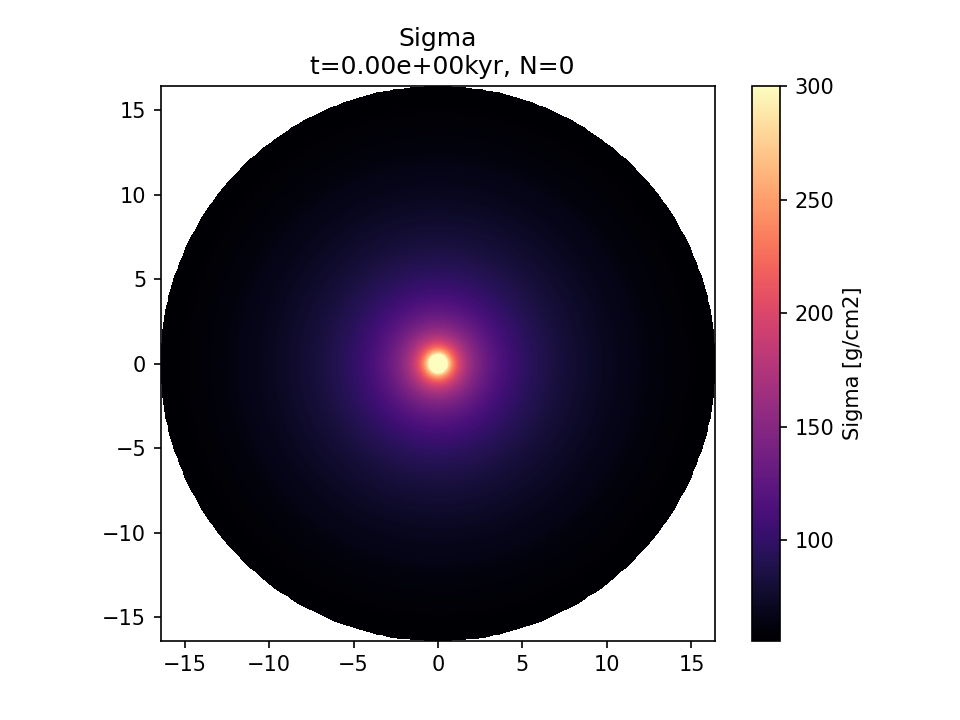

In [125]:
%matplotlib widget
Nlast = l.snapshots[-1]
plot_field(l, "Sigma", Nlast, dataunit="g/cm2", cmap="magma", title="Sigma", vmax=300);

Text(0, 0.5, 'y [au]')

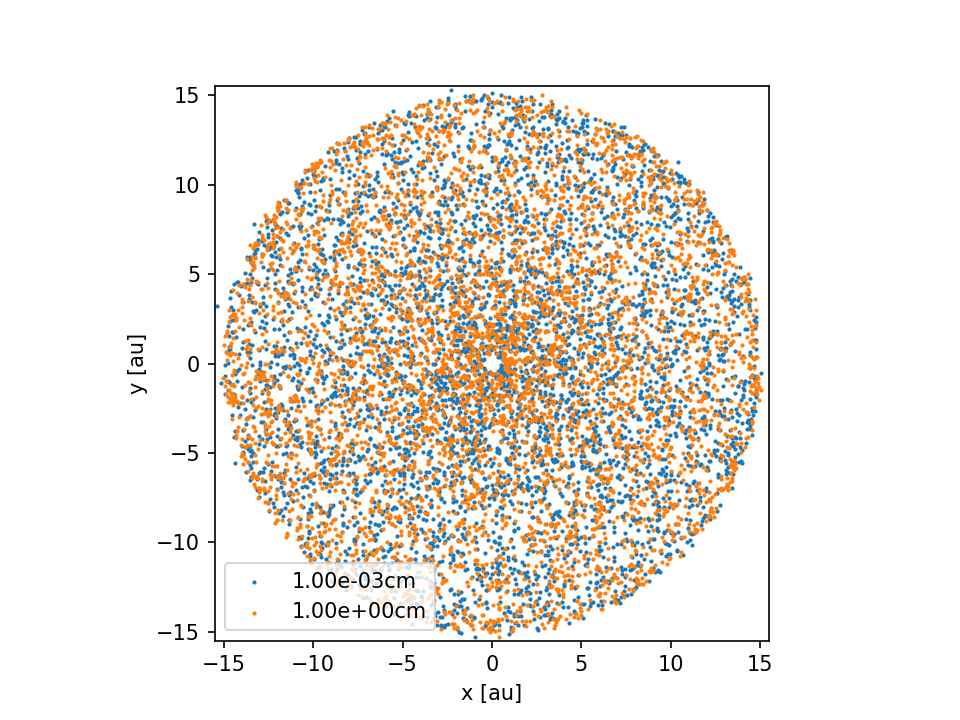

In [49]:
%matplotlib widget
# load dust coordinates into local variables
Nlast = Nlast -1

xs = l.particles.get("x", Nlast)
ys = l.particles.get("y", Nlast)
rs = l.particles.get("r", Nlast)
phis = l.particles.get("phi", Nlast).to_value("rad")

# get the unique sizes and sort the particles by size
size = l.particles.get("size", Nlast).to("cm")
unique_sizes = np.unique(size)
unique_sizes

inds_size = {s : np.where(size==s) for s in unique_sizes}

dust = {}
for nd, s in enumerate(unique_sizes):
    dust[nd] = {}
    dust[nd]["x"] = xs[inds_size[s]]
    dust[nd]["y"] = ys[inds_size[s]]
    dust[nd]["r"] = rs[inds_size[s]]
    dust[nd]["phi"] = phis[inds_size[s]]
    dust[nd]["size"] = s


fig, ax = plt.subplots(dpi=150)
for nd, val in dust.items():
    s = val["size"]
    ax.scatter(val["x"], val["y"],label=f"{s.to_value('cm'):.2e}cm", s=1)
ax.legend()

# ax.scatter(x, y, s=1)
psize = 15.5
ax.set_aspect("equal")
ax.set_xlim([-psize,psize])
ax.set_ylim([-psize,psize])
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

In [51]:
ms = l.particles.get("mass", Nlast)
s1_r = l.particles.get("r", Nlast)
print(max(ms))

5.5823291488852906e-33 1.98847e+33 g


In [69]:
l.gas.vars2D

   Vars2D
| output_dir: output/out
| target_units= None
| grid: Grid
| var_names:
|   Sigma
|   vrad
|   vazi
|   energy
____________________

In [20]:
#!pip install git+https://github.com/rometsch/coords2sigma

  Cloning https://github.com/rometsch/coords2sigma to /tmp/pip-req-build-0mk7z3hr
  Running command git clone --filter=blob:none --quiet https://github.com/rometsch/coords2sigma /tmp/pip-req-build-0mk7z3hr
  Resolved https://github.com/rometsch/coords2sigma to commit 06f5edbdbad6e1610133b1974d4e578763e1d327
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [21]:
import coords2sigma

In [22]:
l.gas.grid

   Grid
| radi: 0.39008713180416776 1.49598e+13 cm ... 16.40659093367089 1.49598e+13 cm
| phii: 0.0 ... 6.283185307179586
| Nrad: 149
| Naz: 251
| Spacing: Logarithmic
____________________

In [23]:
r_g_i = l.gas.grid.radi.to("au")
phi_g_i = l.gas.grid.phii

R_g_i_au, PHI_g_i_rad = np.meshgrid(r_g_i.to_value("au"), phi_g_i, indexing="ij")
X_g_i_au = R_g_i_au*np.cos(PHI_g_i_rad)
Y_g_i_au = R_g_i_au*np.sin(PHI_g_i_rad)

r_g_i_au = r_g_i.to_value("au")
r_g_c_au = 0.5*(r_g_i_au[:-1] + r_g_i_au[1:])

In [24]:
coords2sigma.resample_grid?

Signature: coords2sigma.resample_grid(q1_i, q2_i, N, N_2=None, polar=False)
Docstring:
Resample the coordinates of a regular grid.

The grid is resampled to have squared cells if N_2 is not defined.
Supported are linarly spaced and logarithmically spaced coordinates.

For polar grids with linear radial spacing, the parameter N_2 has to be defined.

Args:
    q1_i (np.array(double)): Interface coordinates in first direction.
    q2_i (np.array(double)): Interface coordinates in first direction.
    N (int): Number of grid cells in first direction.
    N_2 (int, optional): Number of grid cells in first direction.
    polar (bool): Specify whether it is a squred grid.

Returns:
    (new_q1, new_q2) (np.array(double), np.array(double)): New corrdinate arrays.

Raises:
    ValueError: For a polar grid with linear radial spacing, if N_2 is not defined.
File:      ~/.python/current/lib/python3.10/site-packages/coords2sigma.py
Type:      function

In [25]:
Nr = 64
import astropy.units as u
r_i, phi_i = coords2sigma.resample_grid(r_g_i.to_value("cm"), phi_g_i, N=Nr, polar=True)
r_i = r_i * u.cm
phi_i = phi_i

In [26]:
print("Old", r_g_i.shape, phi_g_i.shape)
print("New", r_i.shape, phi_i.shape)

Old (150,) (252,)
New (64,) (106,)


In [27]:
sigmads = {}
for nd, d in dust.items():
    sd = coords2sigma.surface_density_from_distribution(
        d["r"].to_value("au"),
        d["phi"], 
        r_i.to_value("au"), 
        phi_i, 
        polar=True)
    d["sigma"] = sd

In [28]:
r_i_au = r_i.to_value("au")
phi_i_rad = phi_i
R_i_au, PHI_i_rad = np.meshgrid(r_i_au, phi_i_rad, indexing="ij")
X_i_au = R_i_au*np.cos(PHI_i_rad)
Y_i_au = R_i_au*np.sin(PHI_i_rad)

(-16.399247873231214, 16.40659093367089)

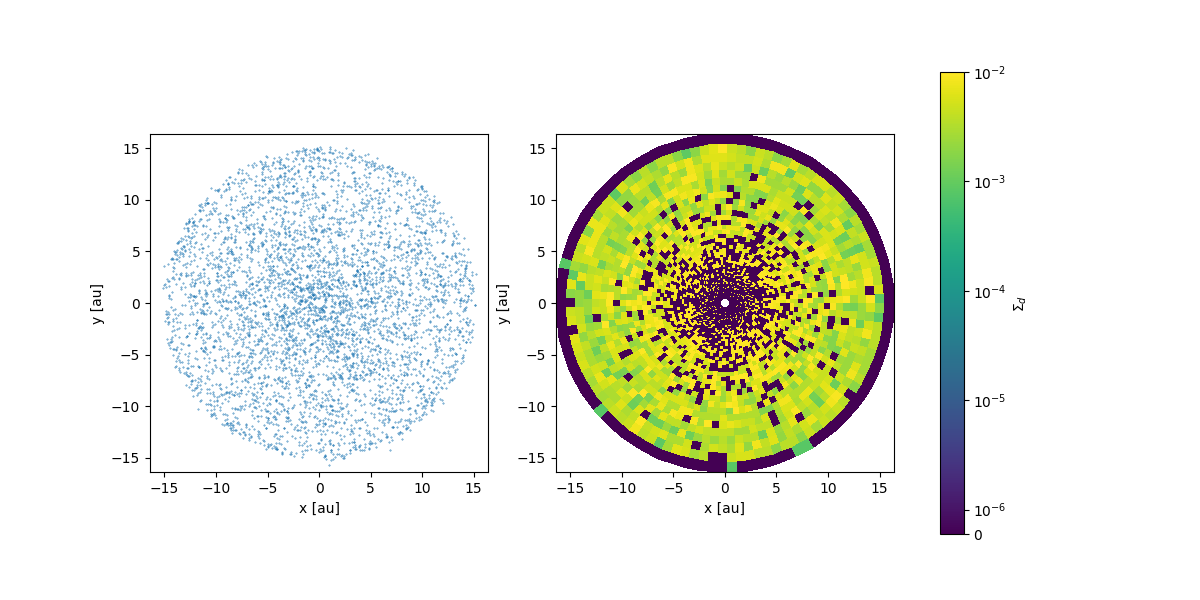

In [29]:
%matplotlib widget
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

nd = 0
rd = dust[nd]["r"].to_value("au")
phid = dust[nd]["phi"]
Xd = rd*np.cos(phid)
Yd = rd*np.sin(phid)
ax = axs[0]
ax.scatter(Xd, Yd, marker=".", s=0.5)
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

ax = axs[1]
Z = dust[nd]["sigma"]/np.max(dust[nd]["sigma"])
norm = mplcolors.SymLogNorm(linthresh=1e-6, linscale=0.2, vmin=0, vmax=1e-2)
pcm = ax.pcolormesh(X_i_au, Y_i_au, Z, norm=norm)
cax = fig.colorbar(pcm, ax=axs)
cax.set_label(r"$\Sigma_d$")
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_xlim(axs[1].get_xlim())

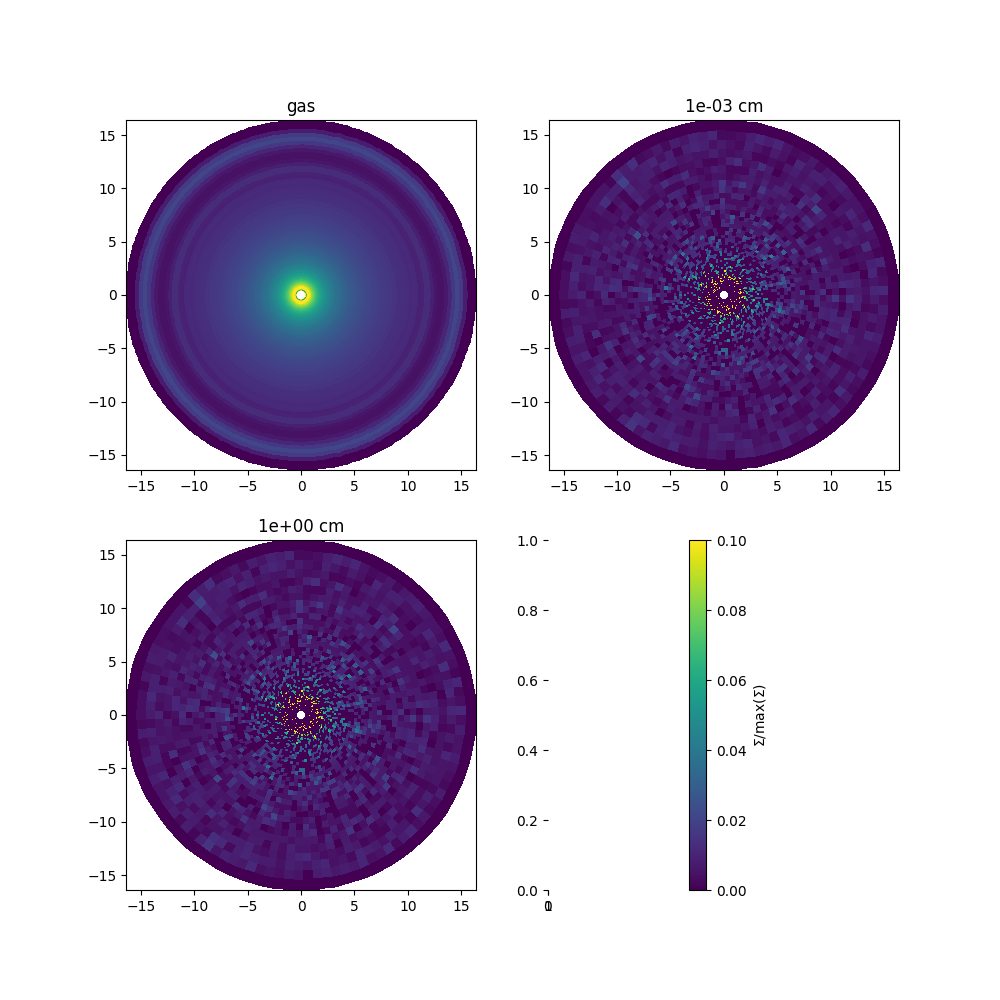

In [30]:
%matplotlib widget
mplcolors.Normalize(vmin=0, vmax=1)

#
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
# make the axes array flat
axs = axs.ravel()

#
# Plot gas
#

N = l.snapshots[-1]
# get the values
Z = l.gas.vars2D.get("Sigma", N, grid=False).to_value("g/cm2")

# make a colormesh plot
pcm = axs[0].pcolormesh(X_g_i_au, Y_g_i_au, Z, rasterized=True, vmax=250)

# decorate
axs[0].set_aspect("equal")
axs[0].set_title("gas")


#
# Plot dust
#

# mask for outer disk for the dust surface densities
r_c_au = 0.5*(r_i_au[:-1] + r_i_au[1:])
inds_outer = r_c_au > 40

dust_vmax = 0.1

for nd, ax in zip(dust, axs[1:]):     
    # get values
    Z = d["sigma"]
    Z = Z / np.max(Z)
    
    # make a colormesh plot
    pcm = ax.pcolormesh(X_i_au, Y_i_au, Z, vmax=dust_vmax, rasterized=True)
    
    # decorate
    ax.set_aspect("equal")
    size = dust[nd]["size"]
    ax.set_title(f"{size:.0e}")

#
# Add a colorbar in the bottom right corner
#
cax = fig.colorbar(pcm, ax=axs[-1], pad=0.4, fraction=0.6, location="right")
cax.set_label(r"$\Sigma/\mathrm{max}(\Sigma)$")

#
# Decoration
#

# Turn off original axes in the bottom right corner
axs[-1].set_frame_on(False)

In [31]:
folder = "imgs_New"
!mkdir -p $folder

In [32]:
l.snapshots[825:]

[]

In [34]:
from tqdm import tqdm
for n in tqdm(l.snapshots[1:]):
    mplcolors.Normalize(vmin=0, vmax=1)
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,10))
    # make the axes array flat
    axs = axs.ravel()

    #
    # Plot gas
    #

    #N = l.snapshots[-1]
    # get the values
    Z = l.gas.vars2D.get("Sigma", n, grid=False).to_value("g/cm2")

    # make a colormesh plot
    pcm = axs[0].pcolormesh(X_g_i_au, Y_g_i_au, Z, rasterized=True, vmax=250)

    # decorate
    axs[0].set_aspect("equal")
    axs[0].set_title("Gas")
    #cbar = fig.colorbar(pcm, ax=axs[0])
    #cbar.set_label("Sigma [g/cm2]")
#
# Plot dust
#

    # mask for outer disk for the dust surface densities
    xs = l.particles.get("x", n)
    ys = l.particles.get("y", n)
    rs = l.particles.get("r", n)
    phis = l.particles.get("phi", n).to_value("rad")

    # get the unique sizes and sort the particles by size
    size = l.particles.get("size", n).to("cm")
    unique_sizes = np.unique(size)
    unique_sizes

    inds_size = {s : np.where(size==s) for s in unique_sizes}

    dust = {}
    for nd, s in enumerate(unique_sizes):
        dust[nd] = {}
        dust[nd]["x"] = xs[inds_size[s]]
        dust[nd]["y"] = ys[inds_size[s]]
        dust[nd]["r"] = rs[inds_size[s]]
        dust[nd]["phi"] = phis[inds_size[s]]
        dust[nd]["size"] = s


    #fig, ax = plt.subplots(dpi=150)
    for nd, val in dust.items():
        s = val["size"]
        axs[1].scatter(val["x"], val["y"],label=f"{s.to_value('cm'):.2e}cm", s=1)
    axs[1].legend(loc = 'upper right')

    psize = 15.5
    axs[1].set_aspect("equal")
    axs[1].set_xlim([-psize,psize])
    axs[1].set_ylim([-psize,psize])
    axs[1].set_xlabel("x [au]")
    axs[1].set_ylabel("y [au]")
    axs[1].set_title("Dust")

    fig.savefig(f"imgs_New/Dust{n}.jpg", dpi=300)
    plt.close(fig)

100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


In [35]:
import os
import moviepy.video.io.ImageSequenceClip
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

image_files = []

for img_number in range(1, 79): 
    image_files.append('imgs_New/Dust' + str(img_number) + '.jpg') 

fps = 30

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('Binary_New_N_body.mp4')

Moviepy - Building video Binary_New_N_body.mp4.
Moviepy - Writing video Binary_New_N_body.mp4



Moviepy - Done !
Moviepy - video ready Binary_New_N_body.mp4


NameError: name 'X_g_i_au' is not defined

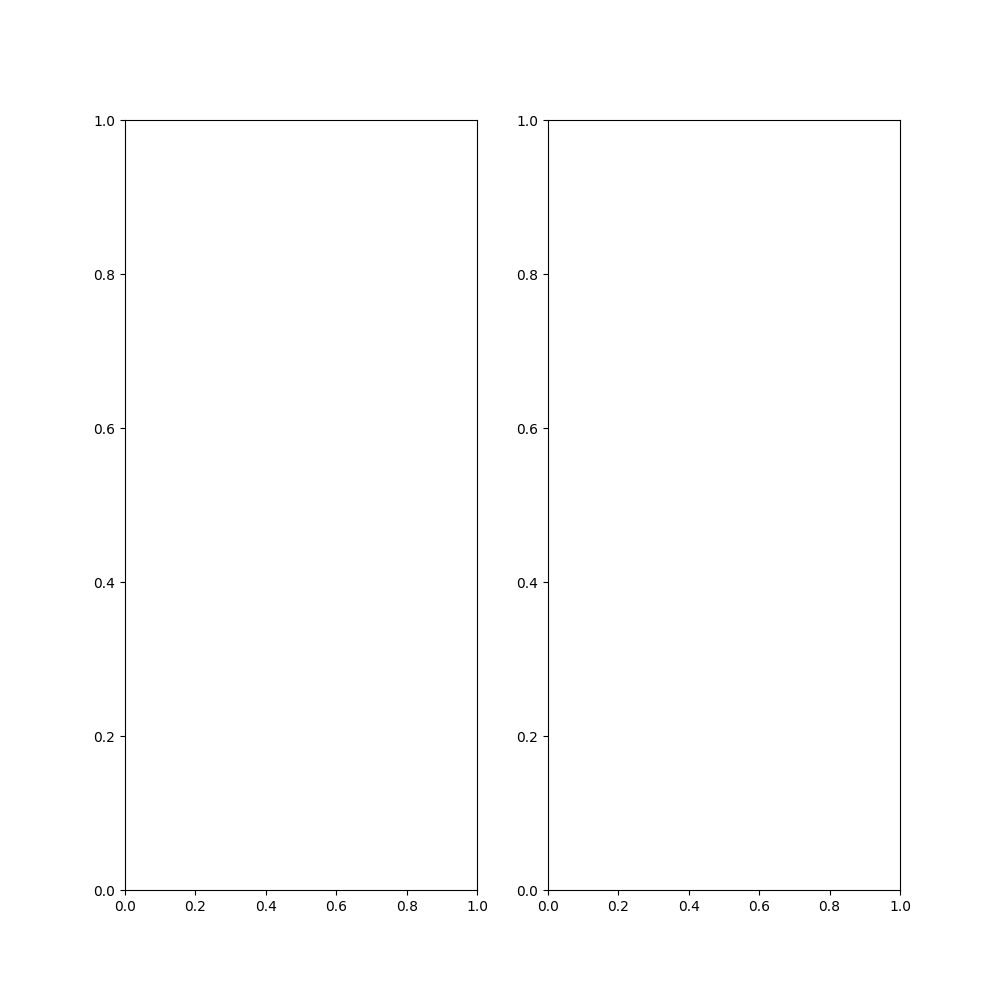

In [ ]:
%matplotlib widget
mplcolors.Normalize(vmin=0, vmax=1)

#
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,10))
# make the axes array flat
axs = axs.ravel()

#
# Plot gas
#

N = l.snapshots[-1]
# get the values
Z = l.gas.vars2D.get("Sigma", N, grid=False).to_value("g/cm2")

# make a colormesh plot
pcm = axs[0].pcolormesh(X_g_i_au, Y_g_i_au, Z, rasterized=True, vmax=250)

# decorate
axs[0].set_aspect("equal")
axs[0].set_title("Gas")
#cbar = fig.colorbar(pcm, ax=axs[0])
#cbar.set_label("Sigma [g/cm2]")

#
# Plot dust
#

# mask for outer disk for the dust surface densities
xs = l.particles.get("x", Nlast)
ys = l.particles.get("y", Nlast)
rs = l.particles.get("r", Nlast)
phis = l.particles.get("phi", Nlast).to_value("rad")

# get the unique sizes and sort the particles by size
size = l.particles.get("size", Nlast).to("cm")
unique_sizes = np.unique(size)
unique_sizes

inds_size = {s : np.where(size==s) for s in unique_sizes}

dust = {}
for nd, s in enumerate(unique_sizes):
    dust[nd] = {}
    dust[nd]["x"] = xs[inds_size[s]]
    dust[nd]["y"] = ys[inds_size[s]]
    dust[nd]["r"] = rs[inds_size[s]]
    dust[nd]["phi"] = phis[inds_size[s]]
    dust[nd]["size"] = s


#fig, ax = plt.subplots(dpi=150)
for nd, val in dust.items():
    s = val["size"]
    axs[1].scatter(val["x"], val["y"],label=f"{s.to_value('cm'):.2e}cm", s=1)
axs[1].legend(loc = 'upper right')

psize = 15.5
axs[1].set_aspect("equal")
axs[1].set_xlim([-psize,psize])
axs[1].set_ylim([-psize,psize])
axs[1].set_xlabel("x [au]")
axs[1].set_ylabel("y [au]")
axs[1].set_title("Dust")

t = loader.snapshot_time[Nlast].to_value("kyr")

fig.suptitle(f" t={t:.2e}kyr")